# CHIRPS Rainfall Data Extraction for Myanmar

This notebook extracts CHIRPS rainfall data from Google Earth Engine for Myanmar at ADM0 (national) and ADM1 (state/region) levels.

In [1]:
# Import required libraries
import ee
import pandas as pd
import geopandas as gpd
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# Authenticate Google Earth Engine
try:
    # First try with service account if available
    service_account_file = "../../training-253313-c905674c1ca0.json"
    if Path(service_account_file).exists():
        print(f"Authenticating with service account: {service_account_file}")
        credentials = ee.ServiceAccountCredentials(None, service_account_file)
        ee.Initialize(credentials)
        print("✓ Google Earth Engine initialized with service account")
    else:
        raise FileNotFoundError("Service account file not found")
except Exception as e:
    print(f"Service account auth failed: {e}")
    print("Trying user authentication...")
    try:
        ee.Initialize()
        print("✓ Google Earth Engine already initialized")
    except:
        print("Authenticating with user credentials...")
        ee.Authenticate()
        ee.Initialize()
        print("✓ Google Earth Engine authenticated and initialized")

Authenticating with service account: ../../training-253313-c905674c1ca0.json
✓ Google Earth Engine initialized with service account


In [3]:
# Set parameters
start_date = "2012-01-01"
end_date = "2025-09-30"
temporal_resolution = "monthly"

# Myanmar bounding box
myanmar_bbox = ee.Geometry.Rectangle([92.2, 9.5, 101.2, 28.5])

print(f"Extracting rainfall data from {start_date} to {end_date}")
print(f"Temporal resolution: {temporal_resolution}")

Extracting rainfall data from 2012-01-01 to 2025-09-30
Temporal resolution: monthly


## 1. Extract National-Level (ADM0) Rainfall

In [4]:
# Load CHIRPS dataset
print("Loading CHIRPS dataset...")
chirps = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .filterDate(start_date, end_date)
    .filterBounds(myanmar_bbox)
)


# Aggregate to monthly
def monthly_sum(date):
    date = ee.Date(date)
    monthly = chirps.filterDate(date, date.advance(1, "month")).sum()
    return monthly.set("system:time_start", date.millis())


# Get list of monthly dates
start = ee.Date(start_date)
end = ee.Date(end_date)
months = end.difference(start, "month").round()
monthly_dates = ee.List.sequence(0, months.subtract(1)).map(
    lambda m: start.advance(m, "month")
)

chirps_monthly = ee.ImageCollection.fromImages(monthly_dates.map(monthly_sum))
print("✓ Created monthly aggregation")

Loading CHIRPS dataset...
✓ Created monthly aggregation


In [5]:
# Extract national-level rainfall
print("Extracting national-level rainfall...")


def extract_rainfall(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=myanmar_bbox,
        scale=5000,  # 5km resolution
        maxPixels=1e9,
    )

    return ee.Feature(
        None,
        {
            "date": image.date().format("YYYY-MM-dd"),
            "rainfall_mm": stats.get("precipitation"),
            "region": "Myanmar",
        },
    )


features = chirps_monthly.map(extract_rainfall)
data = features.getInfo()

# Convert to DataFrame
records_adm0 = []
for feature in data["features"]:
    props = feature["properties"]
    if props["rainfall_mm"] is not None:
        records_adm0.append(
            {
                "region": props["region"],
                "date": pd.to_datetime(props["date"]),
                "rainfall_mm": props["rainfall_mm"],
            }
        )

df_adm0 = pd.DataFrame(records_adm0)
df_adm0 = df_adm0.sort_values("date").reset_index(drop=True)

print(f"✓ Extracted {len(df_adm0)} national-level records")
df_adm0.head()

Extracting national-level rainfall...
✓ Extracted 165 national-level records


,region,date,rainfall_mm
0,Myanmar,2012-01-01,12.997127
1,Myanmar,2012-02-01,12.481557
2,Myanmar,2012-03-01,30.771827
3,Myanmar,2012-04-01,89.187830
4,Myanmar,2012-05-01,220.709918


In [6]:
# Save ADM0 data
output_dir = Path("../../data/rainfall")
output_dir.mkdir(parents=True, exist_ok=True)

output_file_adm0 = (
    output_dir / f"myanmar_chirps_rainfall_{start_date}_{end_date}_monthly_adm0.csv"
)
df_adm0.to_csv(output_file_adm0, index=False)
print(f"✓ Saved to: {output_file_adm0}")

✓ Saved to: ../../data/rainfall/myanmar_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm0.csv


## 2. Extract State/Region-Level (ADM1) Rainfall

In [7]:
# Load Myanmar ADM1 boundaries
print("Loading Myanmar ADM1 boundaries...")
boundaries_path = "../../data/boundaries/mmr_polbnda_adm1_250k_mimu_20240215.shp"
mmr_adm1 = gpd.read_file(boundaries_path)

# Ensure CRS is WGS84
if mmr_adm1.crs is None:
    mmr_adm1 = mmr_adm1.set_crs("EPSG:4326")
elif mmr_adm1.crs != "EPSG:4326":
    mmr_adm1 = mmr_adm1.to_crs("EPSG:4326")

print(f"✓ Loaded {len(mmr_adm1)} states/regions")
print(f"\nRegions: {sorted(mmr_adm1['ADM1_EN'].unique())}")

Loading Myanmar ADM1 boundaries...
✓ Loaded 18 states/regions

Regions: ['Ayeyarwady', 'Bago (East)', 'Bago (West)', 'Chin', 'Kachin', 'Kayah', 'Kayin', 'Magway', 'Mandalay', 'Mon', 'Nay Pyi Taw', 'Rakhine', 'Sagaing', 'Shan (East)', 'Shan (North)', 'Shan (South)', 'Tanintharyi', 'Yangon']


In [8]:
# Extract rainfall for each region
print("\nExtracting rainfall by region (this may take several minutes)...")
all_results = []

for idx, region in mmr_adm1.iterrows():
    region_name = region["ADM1_EN"]
    print(f"Processing {idx + 1}/{len(mmr_adm1)}: {region_name}")

    # Convert geometry to GEE format
    geom_json = region.geometry.__geo_interface__
    ee_geom = ee.Geometry(geom_json)

    # Extract rainfall for this region
    def extract_regional_rainfall(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(), geometry=ee_geom, scale=5000, maxPixels=1e9
        )

        return ee.Feature(
            None,
            {
                "date": image.date().format("YYYY-MM-dd"),
                "rainfall_mm": stats.get("precipitation"),
                "region": region_name,
            },
        )

    try:
        features = chirps_monthly.map(extract_regional_rainfall)
        data = features.getInfo()

        # Add to results
        for feature in data["features"]:
            props = feature["properties"]
            if props["rainfall_mm"] is not None:
                all_results.append(
                    {
                        "region": props["region"],
                        "date": pd.to_datetime(props["date"]),
                        "rainfall_mm": props["rainfall_mm"],
                    }
                )
    except Exception as e:
        print(f"  ⚠ Error processing {region_name}: {e}")
        continue

# Create DataFrame
df_adm1 = pd.DataFrame(all_results)
df_adm1 = df_adm1.sort_values(["region", "date"]).reset_index(drop=True)

print(f"\n✓ Extracted {len(df_adm1)} region-date records")
print(f"✓ Number of regions: {df_adm1['region'].nunique()}")


Extracting rainfall by region (this may take several minutes)...
Processing 1/18: Ayeyarwady
Processing 2/18: Bago (East)
Processing 3/18: Bago (West)
Processing 4/18: Chin
Processing 5/18: Kachin
Processing 6/18: Kayah
Processing 7/18: Kayin
Processing 8/18: Magway
Processing 9/18: Mandalay
Processing 10/18: Mon
Processing 11/18: Nay Pyi Taw
Processing 12/18: Rakhine
Processing 13/18: Sagaing
Processing 14/18: Shan (East)
Processing 15/18: Shan (North)
Processing 16/18: Shan (South)
Processing 17/18: Tanintharyi
Processing 18/18: Yangon

✓ Extracted 2970 region-date records
✓ Number of regions: 18


In [9]:
# Preview the data
df_adm1.head(10)

,region,date,rainfall_mm
0,Ayeyarwady,2012-01-01,0.000153
1,Ayeyarwady,2012-02-01,0.416122
2,Ayeyarwady,2012-03-01,6.292467
3,Ayeyarwady,2012-04-01,17.477283
4,Ayeyarwady,2012-05-01,284.239163
5,Ayeyarwady,2012-06-01,653.356141
6,Ayeyarwady,2012-07-01,750.980160
7,Ayeyarwady,2012-08-01,629.092338
8,Ayeyarwady,2012-09-01,297.597625
9,Ayeyarwady,2012-10-01,118.707858


In [10]:
# Save ADM1 data
output_file_adm1 = (
    output_dir / f"myanmar_chirps_rainfall_{start_date}_{end_date}_monthly_adm1.csv"
)
df_adm1.to_csv(output_file_adm1, index=False)
print(f"✓ Saved to: {output_file_adm1}")

✓ Saved to: ../../data/rainfall/myanmar_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm1.csv


## Summary

In [11]:
print("=" * 60)
print("EXTRACTION COMPLETE - MYANMAR RAINFALL DATA")
print("=" * 60)

print("\n--- ADMIN LEVEL 0 (National) ---")
print(f"Total records: {len(df_adm0)}")
print(f"Date range: {df_adm0['date'].min()} to {df_adm0['date'].max()}")
print(f"File: {output_file_adm0}")

print("\n--- ADMIN LEVEL 1 (States/Regions) ---")
print(f"Total records: {len(df_adm1)}")
print(f"Number of states/regions: {df_adm1['region'].nunique()}")
print(f"Date range: {df_adm1['date'].min()} to {df_adm1['date'].max()}")
print(f"File: {output_file_adm1}")

print("\nRegions included:")
for region in sorted(df_adm1["region"].unique()):
    count = len(df_adm1[df_adm1["region"] == region])
    print(f"  - {region}: {count} records")

EXTRACTION COMPLETE - MYANMAR RAINFALL DATA

--- ADMIN LEVEL 0 (National) ---
Total records: 165
Date range: 2012-01-01 00:00:00 to 2025-09-01 00:00:00
File: ../../data/rainfall/myanmar_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm0.csv

--- ADMIN LEVEL 1 (States/Regions) ---
Total records: 2970
Number of states/regions: 18
Date range: 2012-01-01 00:00:00 to 2025-09-01 00:00:00
File: ../../data/rainfall/myanmar_chirps_rainfall_2012-01-01_2025-09-30_monthly_adm1.csv

Regions included:
  - Ayeyarwady: 165 records
  - Bago (East): 165 records
  - Bago (West): 165 records
  - Chin: 165 records
  - Kachin: 165 records
  - Kayah: 165 records
  - Kayin: 165 records
  - Magway: 165 records
  - Mandalay: 165 records
  - Mon: 165 records
  - Nay Pyi Taw: 165 records
  - Rakhine: 165 records
  - Sagaing: 165 records
  - Shan (East): 165 records
  - Shan (North): 165 records
  - Shan (South): 165 records
  - Tanintharyi: 165 records
  - Yangon: 165 records


## Visualization: Annual Rainfall Patterns

In [12]:
import matplotlib.pyplot as plt

# Add year and month columns for analysis
df_adm0["year"] = df_adm0["date"].dt.year
df_adm0["month"] = df_adm0["date"].dt.month

df_adm1["year"] = df_adm1["date"].dt.year
df_adm1["month"] = df_adm1["date"].dt.month

# Calculate annual rainfall
annual_adm0 = df_adm0.groupby("year")["rainfall_mm"].sum().reset_index()
annual_adm1 = df_adm1.groupby(["region", "year"])["rainfall_mm"].sum().reset_index()

print("Annual rainfall data prepared")
print(f"Years covered: {annual_adm0['year'].min()} to {annual_adm0['year'].max()}")

Annual rainfall data prepared
Years covered: 2012 to 2025


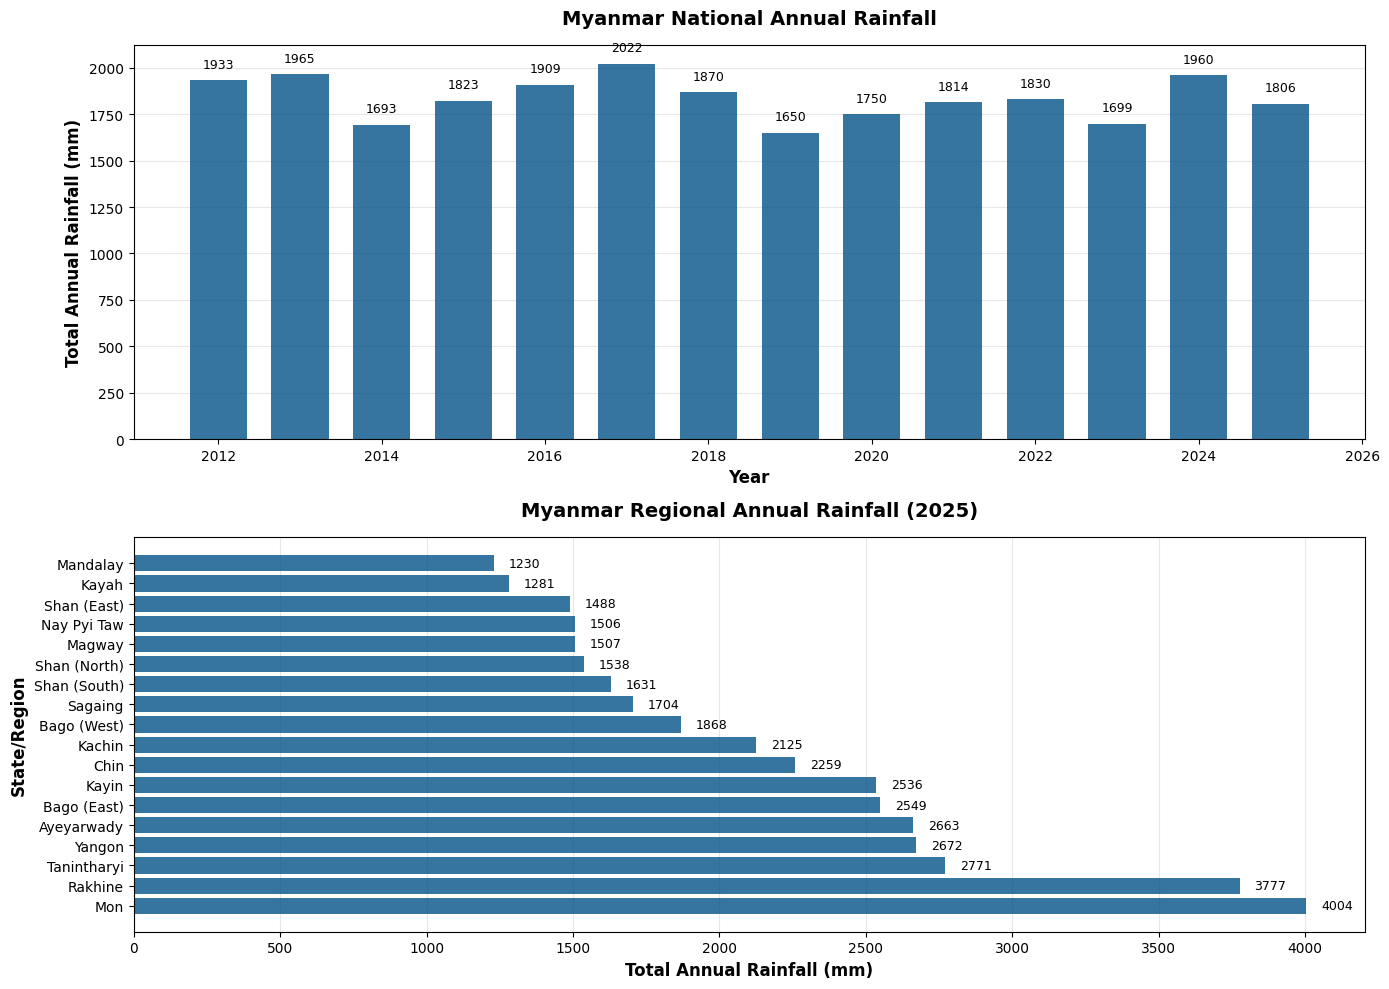


✓ Plots generated successfully


In [13]:
# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: National annual rainfall
ax1 = axes[0]
ax1.bar(
    annual_adm0["year"],
    annual_adm0["rainfall_mm"],
    color="#025288",
    alpha=0.8,
    width=0.7,
)
ax1.set_xlabel("Year", fontsize=12, fontweight="bold")
ax1.set_ylabel("Total Annual Rainfall (mm)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Myanmar National Annual Rainfall", fontsize=14, fontweight="bold", pad=15
)
ax1.grid(True, alpha=0.3, axis="y")
ax1.set_axisbelow(True)

# Add value labels on bars
for year, rainfall in zip(annual_adm0["year"], annual_adm0["rainfall_mm"]):
    ax1.text(
        year, rainfall + 50, f"{rainfall:.0f}", ha="center", va="bottom", fontsize=9
    )

# Plot 2: Regional annual rainfall (2024 comparison)
ax2 = axes[1]
latest_year = annual_adm1["year"].max()
regional_latest = annual_adm1[annual_adm1["year"] == latest_year].sort_values(
    "rainfall_mm", ascending=False
)

bars = ax2.barh(
    regional_latest["region"],
    regional_latest["rainfall_mm"],
    color="#025288",
    alpha=0.8,
)
ax2.set_xlabel("Total Annual Rainfall (mm)", fontsize=12, fontweight="bold")
ax2.set_ylabel("State/Region", fontsize=12, fontweight="bold")
ax2.set_title(
    f"Myanmar Regional Annual Rainfall ({latest_year})",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax2.grid(True, alpha=0.3, axis="x")
ax2.set_axisbelow(True)

# Add value labels
for bar, rainfall in zip(bars, regional_latest["rainfall_mm"]):
    width = bar.get_width()
    ax2.text(
        width + 50,
        bar.get_y() + bar.get_height() / 2,
        f"{rainfall:.0f}",
        ha="left",
        va="center",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

print("\n✓ Plots generated successfully")

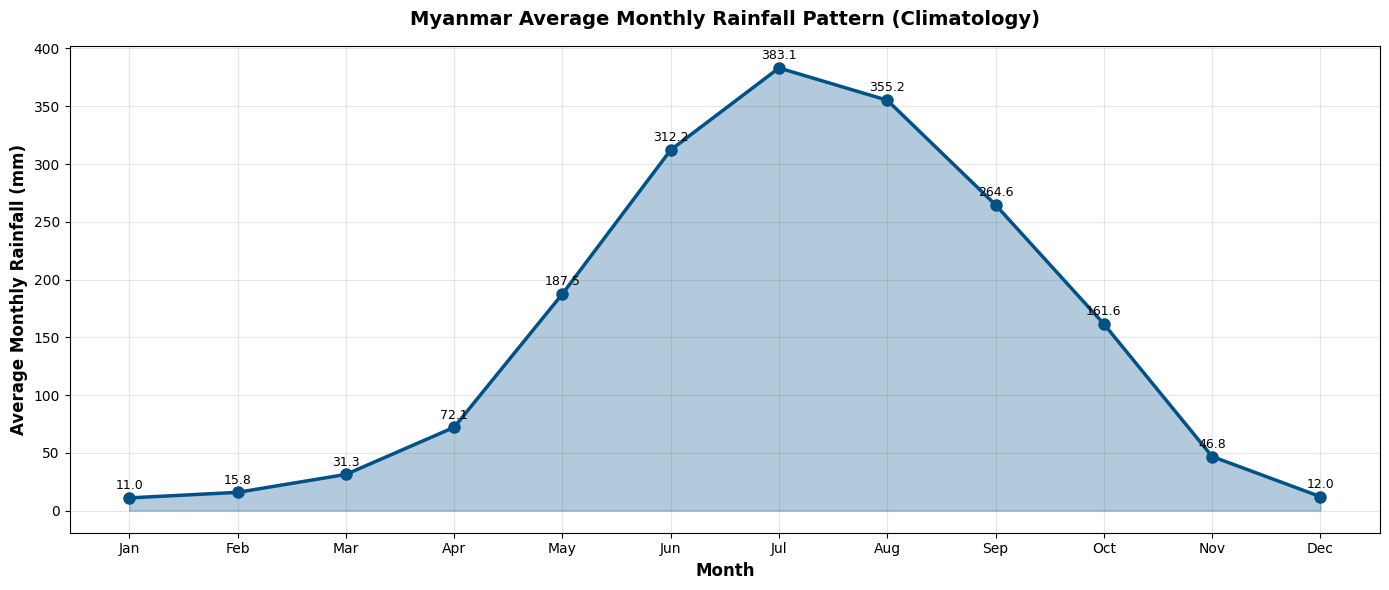


✓ Monthly climatology plot generated


In [14]:
# Additional plot: Monthly rainfall pattern (climatology)
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate average monthly rainfall across all years
monthly_pattern = df_adm0.groupby("month")["rainfall_mm"].mean().reset_index()
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

ax.plot(
    monthly_pattern["month"],
    monthly_pattern["rainfall_mm"],
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#025288",
    label="Average",
)
ax.fill_between(
    monthly_pattern["month"], monthly_pattern["rainfall_mm"], alpha=0.3, color="#025288"
)

ax.set_xlabel("Month", fontsize=12, fontweight="bold")
ax.set_ylabel("Average Monthly Rainfall (mm)", fontsize=12, fontweight="bold")
ax.set_title(
    "Myanmar Average Monthly Rainfall Pattern (Climatology)",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Add value labels
for month, rainfall in zip(monthly_pattern["month"], monthly_pattern["rainfall_mm"]):
    ax.text(
        month, rainfall + 5, f"{rainfall:.1f}", ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()

print("\n✓ Monthly climatology plot generated")